# Setup

In [39]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import concurrent.futures

import seaborn as sns
from sklearn.metrics import mean_squared_error
from likelihood import process_agent, process_agent_map

from utils.evaluation_utils import add_corr_scores, get_model_frequency, plot_confusion_matrix, plot_delta_aic_bic

from likelihood import (
    rl2_sa_neg_log_likelihood,
    rl4_sa_neg_log_likelihood,
    sa_neg_log_likelihood_v2, 
    wm3_sa_neg_log_likelihood, 
    sa_mixture_neg_log_likelihood,
    uniform_prior, 
    beta_prior)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [9]:
BETA_MULTIPLIER = 25
metadata_by_task = {
    "2param_rl": {
        "bounds": {
            "alpha": (0.2, 0.8),
            "beta": (0, 0.4),
        },
        "likelihood_func": rl2_sa_neg_log_likelihood,
    },
    "4param_rl": {
        "bounds": {
            "alpha": (0.2, 0.8),
            "beta": (0, 0.4),
            "neg_alpha": (0.2, 0.8),
            "stickiness": (-0.1, 0.1),
        },
        "likelihood_func": rl4_sa_neg_log_likelihood,
    },    
    "wmh26": {
        "bounds": {
            "alpha": (0, 1),
            "stickiness": (-0.1, 0.1),
            "phi": (0, 0.4),
            "bias": (0, 1),
            "eps": (0, 1),
            "eta6_wm_p": (0, 1),
            "eta2_wm": (0, 1),
        },
        "r0": 1,
        "likelihood_func": sa_mixture_neg_log_likelihood,
        "prior_func": {
            "alpha": beta_prior(0.335, 1, 0, 1),  # beta_prior(0.8, 7.2, 0, 1),
            "stickiness": uniform_prior(-0.1, 0.1),
            "phi": beta_prior(4.4375, 13.3125, 0, 0.4),
            "bias": beta_prior(0.335, 1, 0, 1),
            "eps": beta_prior(0.8, 7.2, 0, 1),
            "eta6_wm_p": beta_prior(28.0, 10.37, 0, 1),
            "eta2_wm": beta_prior(11.9, 2.99, 0, 1),
        },
    },
    "wmh": {
        "bounds": {
            "alpha": (0, 1),
            "stickiness": (-0.05, 0.05),
            "phi": (0, 0.4),
            "bias": (0, 1),
            "eps": (0, 1),
            "eta6_wm": (0, 1),
        },
        "r0": 1,
        "likelihood_func": sa_mixture_neg_log_likelihood,
        "prior_func": {
            "alpha": beta_prior(0.2, 0.8, 0, 1),  # beta_prior(0.8, 7.2, 0, 1),
            "stickiness": uniform_prior(-0.05, 0.05),
            "phi": beta_prior(4.4375, 13.3125, 0, 0.4),
            "bias": uniform_prior(0, 1),
            "eps": beta_prior(0.8, 7.2, 0, 1),
            "eta6_wm": beta_prior(13.79, 9.2, 0, 1),
        },
    },
    "wmbn": {
        "bounds": {
            "stickiness": (-0.2, 0.2),
            "phi": (0, 0.4),
            "bias": (0, 1),
            "eps": (0, 1),
        },
        "likelihood_func": sa_neg_log_likelihood_v2,
        "prior_func": {
            "stickiness": uniform_prior(-0.2, 0.2),
            "phi": beta_prior(4.4375, 13.3125, 0, 0.4),
            "bias": uniform_prior(0, 1),
            "eps": beta_prior(0.8, 7.2, 0, 1),
        },
    },
    "wmb": {
        "bounds": {
            "beta": (0.2, 0.8),
            "stickiness": (-0.2, 0.2),
            "phi": (0, 1),
            "bias": (0, 1),
        },
        "likelihood_func": sa_neg_log_likelihood_v2,
    },
    "wm": {
        "param_names": ["beta", "stickiness", "phi"],
        "bounds": [(0.2, 0.8), (-0.2, 0.2), (0, 0.4)],
        "multipliers": np.array([BETA_MULTIPLIER, 1, 1]),
        "likelihood_func": wm3_sa_neg_log_likelihood,
        # "hello": ["beta", "stickiness", "phi"],
        "prior_func": [
            uniform_prior(0.2, 0.8),
            uniform_prior(-0.2, 0.2),
            beta_prior(4.4375, 13.3125, 0, 0.4),
        ],
    },
    "shared": {
        "param_names": ["alpha0", "alpha1", "beta"],
        "bounds": [(0.01, 1), (0.01, 1), (0.01, 1)],
        "multipliers": np.array([1, 1, 10]),
    },
}

In [24]:
N_TEST_AGENT = 100
num_blocks = 12
num_trials_per_block = 6 * 13
data_model = '2param_rl'

task = f"{data_model}_6s3a"
suffix = f"{data_model}_no_switch"  #''' #'wmh_no_switch_alow
prefix = f"{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}"
data = pd.read_csv(
    f"data/{task}/seq1_{prefix}.csv"
)

# Run Optimizer

In [25]:
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor
import time

# Main execution
start_time = time.time()

# Get unique agent IDs (limit to 200 if needed)
limit = 500
method = "MLE"
all_results = []
agent_ids = data.agentid.unique()
agent_ids = agent_ids[:limit]
process_func = process_agent_map if method == "MAP" else process_agent

fit_model = "4param_rl"
metadata = metadata_by_task[fit_model]
metadata['data_model'] = data_model
metadata['model_name'] = fit_model

max_workers = 4
# Run the optimization in parallel
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_aid = {
        executor.submit(
            process_func,
            aid,
            data,
            metadata,
            metadata["bounds"],
        ): aid
        for aid in agent_ids
    }

    for future in concurrent.futures.as_completed(future_to_aid):
        aid = future_to_aid[future]
        try:
            agent_results = future.result()
            if agent_results:
                all_results.append(agent_results)
        except Exception as e:
            print(f"Agent {aid} generated an exception: {str(e)}")

# Extract parameter estimates into a DataFrame
param_rows = []
for result in all_results:
    # Create a row with agent ID, model names, and all parameters
    row = {
        "id": result["id"],
        "data_model": result["data_model"],
        "fit_model": result["fit_model"],
        "llh": result["llh"],
        "aic": result["aic"],
        "bic": result["bic"],
    }

    # Add each parameter value
    for i, param_name in enumerate(result["param_names"]):
        row[param_name] = result["params"][i]

    param_rows.append(row)

# Create parameter recovery DataFrame
recovered_param = pd.DataFrame(param_rows)

# Print timing information
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Starting optimization for agent 1...
Starting optimization for agent 3...
Starting optimization for agent 0...
Starting optimization for agent 2...
AIC for 0: 274.954374699548
BIC for 0: 294.32083660545834
Starting optimization for agent 4...
AIC for 1: 380.84702624696564
BIC for 1: 400.213488152876
Starting optimization for agent 5...
AIC for 2: 696.6389010506321
BIC for 2: 716.0053629565424
Starting optimization for agent 6...
AIC for 3: 337.92997355526813
BIC for 3: 357.2964354611785
Starting optimization for agent 7...
AIC for 4: 1363.196441945932
BIC for 4: 1382.5629038518425
Starting optimization for agent 8...
AIC for 5: 503.6792466305025
BIC for 5: 523.0457085364129
Starting optimization for agent 9...
AIC for 6: 371.29892558505435
BIC for 6: 390.6653874909647
Starting optimization for agent 10...
AIC for 7: 1881.7341981405048
BIC for 7: 1901.1006600464152
Starting optimization for agent 11...
AIC for 8: 908.2584978348098
BIC for 8: 927.6249597407201
Starting optimization for a

In [26]:
recovered_param

,id,data_model,fit_model,llh,aic,bic,alpha,beta,neg_alpha,stickiness
0,0,2param_rl,4param_rl,133.477187,274.954375,294.320837,0.800000,0.400000,0.800000,0.017208
1,1,2param_rl,4param_rl,186.423513,380.847026,400.213488,0.671268,0.288983,0.800000,-0.018317
2,2,2param_rl,4param_rl,344.319451,696.638901,716.005363,0.505183,0.203845,0.559452,-0.016548
3,3,2param_rl,4param_rl,164.964987,337.929974,357.296435,0.497265,0.353334,0.399175,-0.038885
4,4,2param_rl,4param_rl,677.598221,1363.196442,1382.562904,0.726067,0.114895,0.794536,0.010964
...,...,...,...,...,...,...,...,...,...,...
95,96,2param_rl,4param_rl,535.396726,1078.793451,1098.159913,0.796700,0.140555,0.681443,0.015161
96,97,2param_rl,4param_rl,855.251720,1718.503441,1737.869902,0.200000,0.109492,0.272734,0.035576
97,95,2param_rl,4param_rl,304.700780,617.401560,636.768022,0.249230,0.301125,0.230046,0.028007
98,98,2param_rl,4param_rl,345.156452,698.312903,717.679365,0.346358,0.224764,0.429554,0.014711


# Eval

## Model parameters

In [ ]:
# @title 

from utils.feature_utils import get_labels
from sklearn.metrics import mean_absolute_error

recovered_param = recovered_param.rename(
    columns={"nalpha": "neg_alpha", "bias": "wm_bias"}
)
param_names = list(metadata['bounds'].keys())

if task != "shared":
    shared, conditioned = param_names, []
else:
    shared, conditioned = ["beta"], ["alpha"]

n_cols = len(param_names)
true_name_labels = get_labels(data[data.agentid < limit], shared) #agentid

true_name_labels['beta'] = true_name_labels['beta'] / BETA_MULTIPLIER

fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(3 * n_cols, 3))
for idx, pn in enumerate(sorted(param_names)):
    y_true = true_name_labels[pn].ravel()
    y_pred = recovered_param[pn]
    print(np.max(y_true), np.min(y_true))
    print(np.max(y_pred), np.min(y_pred))
    MAE = mean_absolute_error(
        y_true,
        y_pred,
    )

    # if pn == "alpha" or pn == "eps" or pn == "phi":
    #     min_pv = np.min(y_pred)
    #     if min_pv <= 0:
    #         noise = -min_pv + 0.00001
    #     else:
    #         noise = 0

    #     y_true = -np.log(y_true)
    #     y_pred = -np.log(y_pred + noise)

    result = pd.DataFrame({pn: y_true, method: y_pred})
    ax = sns.regplot(
        data=result,
        ci=None,
        x=pn,
        y=method,
        line_kws=dict(color="#f73e40"),
        scatter_kws=dict(s=10),
        ax=axes.flat[idx],
    )
    ax.plot(
        [ax.get_xlim()[0], ax.get_xlim()[1]],
        [ax.get_xlim()[0], ax.get_xlim()[1]],
        color="black",
        alpha=0.9,
        linestyle="dashed",
    )
    sns.despine()

    ax = add_corr_scores(ax, y_true, y_pred)
    ax.text(0.1, 0.8, f"MAE: {MAE:.3f}", transform=ax.transAxes, fontsize=10)
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Estimated")
    ax.set_title(pn, fontsize=12)

fig.suptitle(method, y=1.01)

KeyError: 'Column not found: neg_alpha'

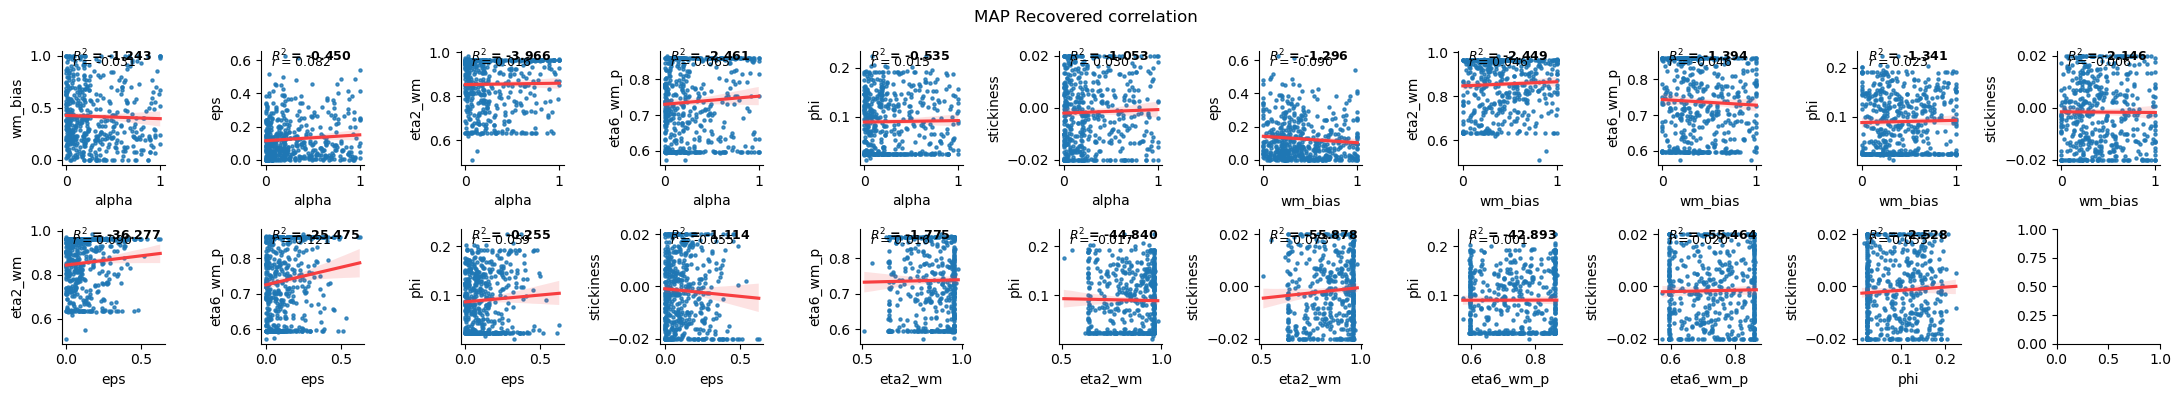

In [ ]:
import math

n_col = len(param_names) * (len(param_names) - 1) // 2
n_row = 2
n_col = math.ceil(n_col / n_row)
fig, axes = plt.subplots(n_row, n_col, figsize=(2 * n_col, 2 * n_row))
# multipliers = {p: metadata["multipliers"][i] for i, p in enumerate(param_names)}
ai = 0
flatted_axes = axes.flatten()
for i, pn1 in enumerate(param_names):
    for j, pn2 in enumerate(param_names[i + 1 :]):
        y_true, y_pred = recovered_param[pn1], recovered_param[pn2]
        ax = flatted_axes[ai]
        sns.regplot(
            x=y_true,
            y=y_pred,
            ax=ax,
            line_kws=dict(color="#f73e40"),
            scatter_kws=dict(s=5),
        )
        ax = add_corr_scores(ax, y_true, y_pred)
        ax.set_xlabel(pn1)
        ax.set_ylabel(pn2)
        ai += 1

sns.despine()
fig.suptitle(f"{method} Recovered correlation")
fig.tight_layout()

## Save data

In [29]:
old = pd.read_csv('results/MLE_2param_rl_6s3a_100a_4param_rl_no_switch.csv')
all_results = pd.concat([old, recovered_param]) 
all_results

,Unnamed: 0,id,data_model,fit_model,llh,aic,bic,alpha,beta,neg_alpha,stickiness
0,0.0,0,2param_rl,2param_rl,133.714449,271.428898,281.112129,0.800000,0.400000,NaN,NaN
1,1.0,1,2param_rl,2param_rl,186.908778,377.817555,387.500786,0.795021,0.280511,NaN,NaN
2,2.0,2,2param_rl,2param_rl,344.569252,693.138504,702.821735,0.528367,0.202068,NaN,NaN
3,3.0,4,2param_rl,2param_rl,677.731472,1359.462943,1369.146174,0.787640,0.113349,NaN,NaN
4,4.0,3,2param_rl,2param_rl,166.327101,336.654203,346.337434,0.409389,0.374555,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,96,2param_rl,4param_rl,535.396726,1078.793451,1098.159913,0.796700,0.140555,0.681443,0.015161
96,NaN,97,2param_rl,4param_rl,855.251720,1718.503441,1737.869902,0.200000,0.109492,0.272734,0.035576
97,NaN,95,2param_rl,4param_rl,304.700780,617.401560,636.768022,0.249230,0.301125,0.230046,0.028007
98,NaN,98,2param_rl,4param_rl,345.156452,698.312903,717.679365,0.346358,0.224764,0.429554,0.014711


In [30]:
# prefix = f"{N_TEST_AGENT}a_{num_blocks}b_{num_trials_per_block}t_{suffix}"
# recovered_param.to_csv(f"results/{method}_{task}_{prefix}.csv")

all_results.to_csv('results/MLE_2param_rl_6s3a_100a_4param_rl_no_switch.csv', index=False)

## Model identification

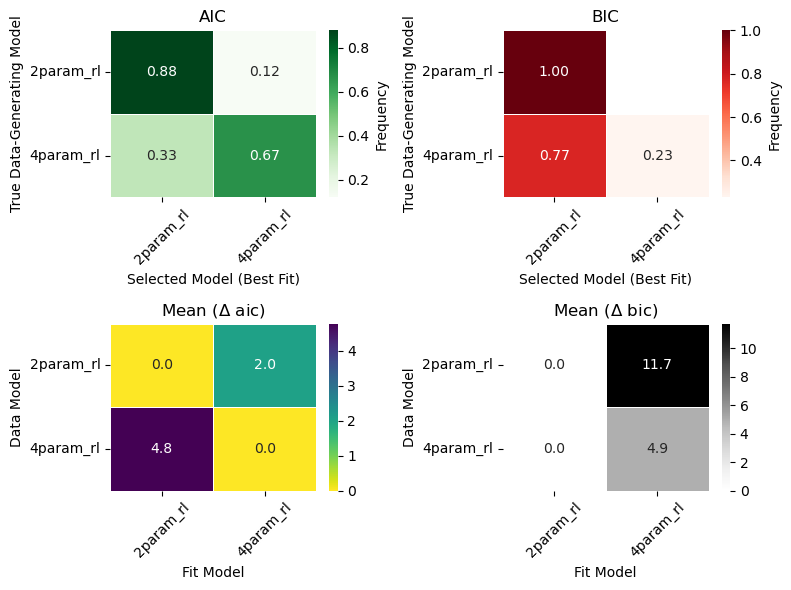

In [44]:
model_frequency = get_model_frequency(all_results)

metrics = ["aic", "bic"]
n_col = len(metrics)
n_row = 2
fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, n_row * 3), sharey=False)

for i, matrix_name in enumerate(metrics):
    ax = axes[0, i]
    ax = plot_confusion_matrix(
        model_frequency[model_frequency["type"] == matrix_name], matrix_name, ax
    )
    ax.set_title(matrix_name.upper())
    # Set the colormap based on the matrix type
    # For AIC, use a blue colormap; for BIC, use a red colormap
    cmap = "Greens" if matrix_name == "aic" else "Reds"
    # Update the heatmap colormap
    ax.collections[0].set_cmap(cmap)
    ax = plot_delta_aic_bic(all_results, matrix_name, axes[1, i])

plt.tight_layout()